In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
%matplotlib inline
import numpy.polynomial.polynomial as poly

In [2]:
# Read the input
vid = cv2.VideoCapture('./test2.avi')

# Get frame count
n_frames = int(vid.get(cv2.CAP_PROP_FRAME_COUNT))
print(n_frames)

# Width and height
w = int(vid.get(cv2.CAP_PROP_FRAME_WIDTH))
h = int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT))

# FPS
fps = vid.get(cv2.CAP_PROP_FPS)

# Set up output
# fourcc = cv2.VideoWriter_fourcc(*'MJPG')
fourcc = cv2.VideoWriter_fourcc(*'MP4V')
out = cv2.VideoWriter('test_stable.mp4', fourcc, fps, (w, h))

456


In [3]:
# Read first frame
_, prev = vid.read()

# Grayscale
prev_gray = cv2.cvtColor(prev, cv2.COLOR_BGR2GRAY)

In [4]:
# Transformation matrix
transforms = np.zeros((n_frames - 1, 3), np.float32)

for i in range(n_frames - 2):
    # Previous frame feature points
    prev_pts = cv2.goodFeaturesToTrack(prev_gray, maxCorners=200, qualityLevel=0.01, minDistance=30, blockSize=3)

    flag, frame = vid.read()
    if not flag:
        break

    frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Optical flow
    frame_pts, status, err = cv2.calcOpticalFlowPyrLK(prev_gray, frame_gray, prev_pts, None)

    # Sanity check
    assert frame_pts.shape == prev_pts.shape

    # Valid pts
    idx = np.where(status == 1)[0]
    prev_pts = prev_pts[idx]
    frame_pts = frame_pts[idx]

    # Transformation matrix
    mat = cv2.estimateAffine2D(prev_pts, frame_pts)[0]

    # Translation
    dx = mat[0][2]
    dy = mat[1][2]

    # Rotation
    dtheta = np.arctan2(mat[1, 0], mat[0, 0])

    transforms[i] = [dx ,dy, dtheta]

    # Next frame
    prev_gray = frame_gray

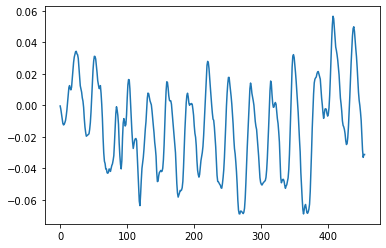

In [5]:
# Trajectory
trajectory = np.cumsum(transforms, axis=0)

plt.plot(np.arange(len(trajectory)),trajectory[:,2])

In [6]:
# Moving average filter
def mav_filter(curve, radius):
    window_size = 2*radius + 1
    filter = np.ones(window_size) / window_size
    # Padding
    curve_padded = np.lib.pad(curve, (radius, radius), 'edge')
    curve_smooth = np.convolve(curve_padded, filter, mode='same')
    # Remove padding
    curve_output = curve_smooth[radius:-radius]

    return curve_output

In [7]:
# Smooth the trajectory
def smooth(trajectory, radius=7):
    trajectory_smooth = np.copy(trajectory)

    for i in range(3):
        trajectory_smooth[:, i] = mav_filter(trajectory[:, i], radius)

    return trajectory_smooth

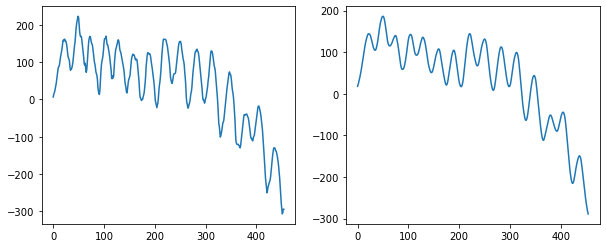

In [8]:
trajectory_smooth = smooth(trajectory)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(np.arange(len(trajectory)),trajectory[:,0])
plt.subplot(1,2,2)
plt.plot(np.arange(len(trajectory_smooth)),trajectory_smooth[:,0])
plt.savefig('theta.png')

44.22733561162053
6.391902357288185
9.852358094242169e-06


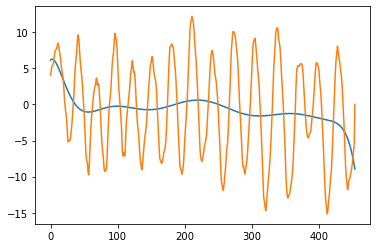

(455, 3)


In [9]:
trajectory_der = np.zeros((len(trajectory_smooth), 3))
ffit_matrix = np.zeros((len(trajectory_smooth), 3))

for j in range (3):
    for i in range(len(trajectory)-1):
        trajectory_der[i][j] = trajectory_smooth[i+1][j] - trajectory_smooth[i][j]

# trajectory_der[:,0] /= np.var(trajectory_der[:,0])
# trajectory_der[:,1] /= np.var(trajectory_der[:,1])

for j in range(3):
    y = trajectory_der[:,j]
    degree = 11
    x = np.arange(len(trajectory_smooth))
    #coeff = np.polyfit(np.arange(len(trajectory_smooth)), y, degree)

    coefs = poly.polyfit(x, y, degree)
    ffit = poly.polyval(x, coefs)
    ffit_matrix[:,j] = ffit
        
    print(np.var(trajectory_der[:,j]))


plt.figure()
plt.plot(np.arange(len(trajectory)),ffit_matrix[:,0])
plt.plot(np.arange(len(trajectory)),trajectory_der[:,0])
plt.show()
trajectory_smooth2 = (np.cumsum(ffit_matrix,axis=0))
print(trajectory_smooth2.shape)

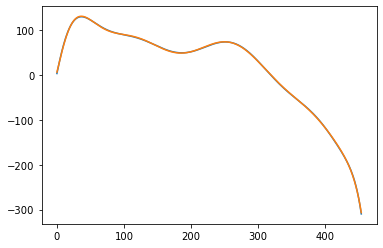

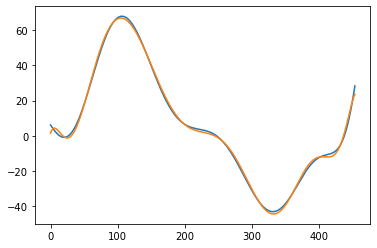

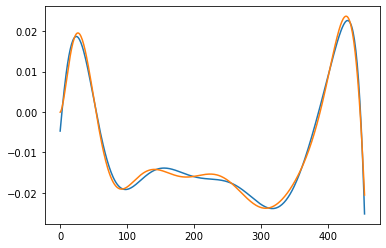

In [10]:
my_trajectory = np.zeros_like(trajectory_smooth2)

for i in range(len(trajectory[0])):
    y = trajectory_smooth2[:,i]
    degree = 11
    x = np.arange(len(trajectory_smooth2))
    #coeff = np.polyfit(np.arange(len(trajectory_smooth)), y, degree)

    coefs = poly.polyfit(x, y, degree)
    ffit = poly.polyval(x, coefs)
    my_trajectory[:,i] = ffit
    plt.figure()
    plt.plot(x, ffit)
    plt.plot(x,y)
    
    plt.savefig(f"{i}.png")



In [11]:
# Difference
trajectory_difference = my_trajectory - trajectory

# New transformations
transforms_smooth = transforms + trajectory_difference

In [12]:
# Fix border by scaling the image about its center
def fix_border(frame):
    n = frame.shape
    T = cv2.getRotationMatrix2D((n[1]/2, n[0]/2), 0, 1.04)
    frame_out = cv2.warpAffine(frame, T, (n[1], n[0]))

    return frame_out

In [13]:
# Reset stream to first frame
vid.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Transform
for i in range(n_frames - 2):
    flag, frame = vid.read()
    if not flag:
        break

    dx = transforms_smooth[i, 0]
    dy = transforms_smooth[i, 1]
    dtheta = transforms_smooth[i, 2]
    
    # Construct transformation matrix
    mat = np.zeros((2, 3), np.float32)
    mat[0, 0] = np.cos(dtheta)
    mat[0, 1] = -np.sin(dtheta)
    mat[1, 0] = np.sin(dtheta)
    mat[1, 1] = np.cos(dtheta)
    mat[0, 2] = dx
    mat[1, 2] = dy

    # Apply the transformation
    frame_stabilized = cv2.warpAffine(frame, mat, (w, h))
    frame_stabilized = fix_border(frame_stabilized)

    # Write to file
    # frame_out = cv2.hconcat([frame, frame_stabilized])
    frame_out = frame_stabilized

    # If too big, resize
    if(frame_out.shape[1] > 1920):
        frame_out = cv2.resize(frame_out, (w, h))
    
    #cv2.imshow('frame', frame_out)
    #cv2.waitKey(10)
    out.write(frame_out)

vid.release()
out.release()
cv2.destroyAllWindows()